## Imports and libraries

Data source: 

The dataset is obatined from Kaggle:

https://www.kaggle.com/code/anuf13/twitter-sentiment-analysis/input?select=Tweets.csv

In [38]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tabulate import tabulate

# preprocessing 
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem.porter import PorterStemmer as ps
# from nltk.stem import WordNetLemmatizer as WL

# predictive modeling 
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve

# further tagging 
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("Tweets.csv")
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df 

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [3]:
df.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [4]:
print(df.dtypes)
print('-------------')
print(df.isnull().sum())

textID           object
text             object
selected_text    object
sentiment        object
dtype: object
-------------
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


## Preprocess text

Basic Text Preprocessing methods:
1. Convert to lowercase
2. Tokenization
3. Remove punctuation
4. Remove stop words

In [7]:
class data_preprocessing():
    def __init__(self, df):
        self.df = df.drop_duplicates()

    def get_df(self):
        return self.df

    def get_cleaned(self):
        self.df['cleaned_text'] = self.df['text'].apply(self.clean_text)
        return self.df

    def clean_text(self, text):
        # remove urls/hyperlinks
        text = re.sub(r'((www\.[^\s]+)|(http\S+))',' ', text)
        # remove hashtags
        text = re.sub(r'#\w+', ' ', text)
        # remove mentions
        text = re.sub(r'@\w+',' ', text)
        # remove characters that are not in the English alphabets
        text = re.sub('[^a-zA-Z]',' ',text)
        # remove additional white spaces
        text = re.sub('[\s]+', ' ', text)
        # remove all the emojis
        text = re.sub('[^\x00-\x7F]+', '',text)
        # remove all the numbers
        text = re.sub(r'\s?[0-9]+\.?[0-9]*', '',text)
        # remove repeated characters
        text = re.sub(r'(.)\1{3,}',r'\1', text)
        
        # convert to lowercase
        text = text.lower()
        # Tokenize the text
        words = nltk.word_tokenize(text)
        # remove stopwords
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in words if word not in stop_words]

        # Example: Remove words with fewer than 3 characters
        min_word_length = 3  
        filtered_words = [word for word in filtered_words if len(word) > min_word_length]
        
        # Join the filtered words back into a single string
        cleaned_text = ' '.join(filtered_words)
        
        return cleaned_text 
    
    def text_transform(self):
        # bag of words
        sentence_count = CountVectorizer(max_features = 1500).fit_transform(self.df['cleaned_text'])
        df_sentence_count = pd.DataFrame(sentence_count.toarray())
        return df_sentence_count
    
    def label_sentence(self):
        label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        self.df['sentiment_encoded'] = self.df['sentiment'].map(label_mapping)
        return self.df['sentiment_encoded']

In [8]:
data_pre = data_preprocessing(df)
df = data_pre.get_cleaned()
y = data_pre.label_sentence()
X = data_pre.text_transform()
df = data_pre.get_df()

In [9]:
df.head()

,textID,text,selected_text,sentiment,cleaned_text,sentiment_encoded
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo miss diego,0
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons releases already bought,0


In [10]:
df.tail()

,textID,text,selected_text,sentiment,cleaned_text,sentiment_encoded
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish could come denver husband lost afford,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,wondered rake client made clear force devs lea...,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,good enjoy break probably need hectic weekend ...,2
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth,2
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,flirting going smiles hugs,1


In [12]:
df.to_csv('Preprocessed_Tweets.csv')

## EDA

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   textID             27480 non-null  object
 1   text               27480 non-null  object
 2   selected_text      27480 non-null  object
 3   sentiment          27480 non-null  object
 4   cleaned_text       27480 non-null  object
 5   sentiment_encoded  27480 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [14]:
print(df.dtypes)
print('-------------')
print(df.isnull().sum())

textID               object
text                 object
selected_text        object
sentiment            object
cleaned_text         object
sentiment_encoded     int64
dtype: object
-------------
textID               0
text                 0
selected_text        0
sentiment            0
cleaned_text         0
sentiment_encoded    0
dtype: int64


neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


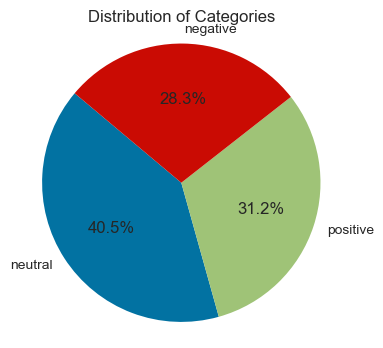

In [15]:
# sentiment categories
cat_counts = df['sentiment'].value_counts()
print(cat_counts)
plt.figure(figsize=(4,4))
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')

plt.title('Distribution of Categories')
plt.show()

In [16]:
df_pos = df[df['sentiment']=='positive']
df_neg = df[df['sentiment']== 'negative']
df_neut = df[df['sentiment']=='neutral']

In [17]:
# wordCloud
def plt_wordcloud(text, color, s):
    cloud_words = "".join(text)
    wordcloud = WordCloud(background_color=color).generate(cloud_words)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis("off")
    plt.show()

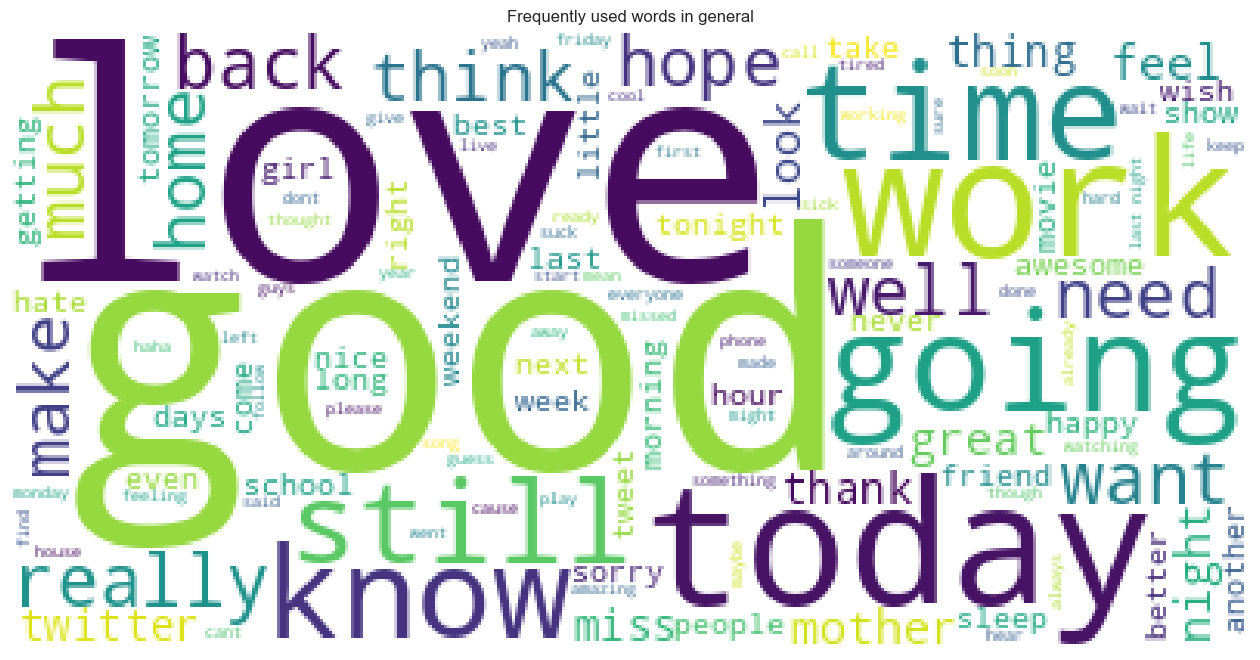

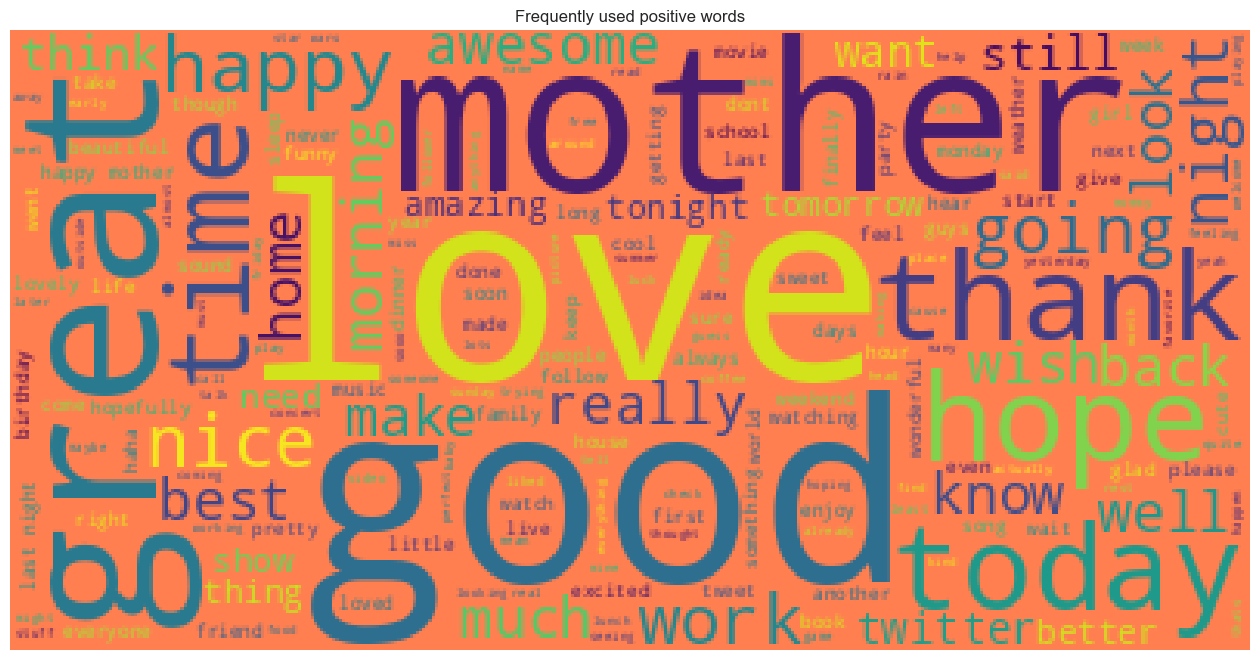

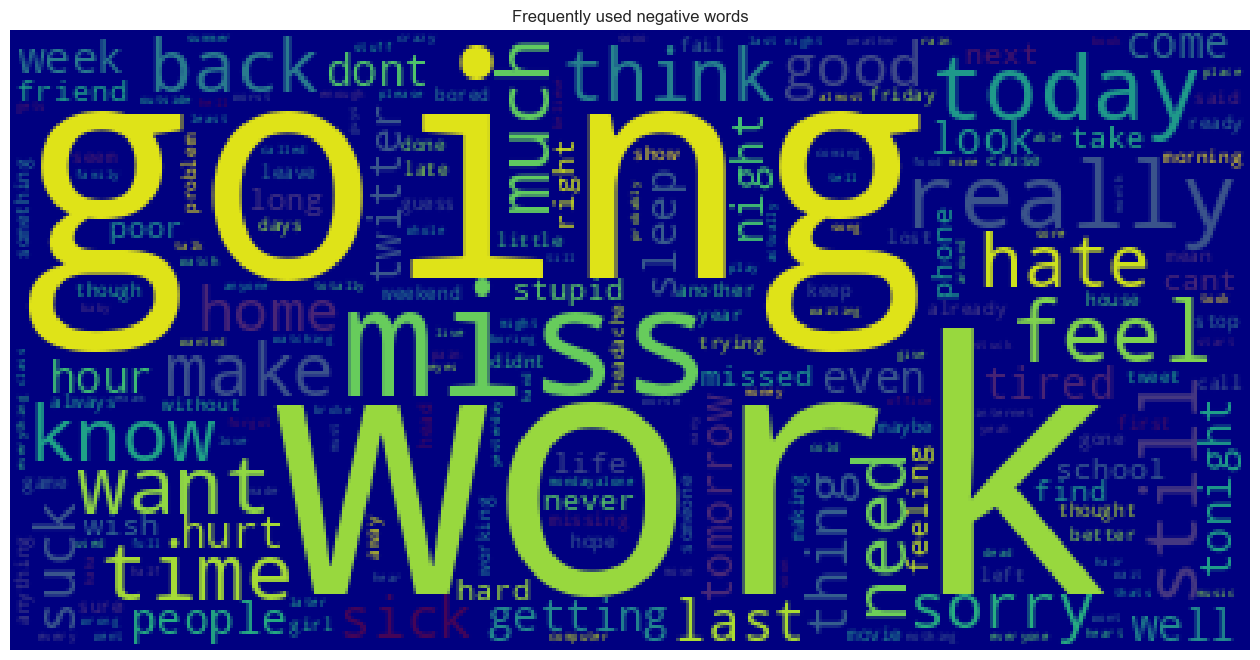

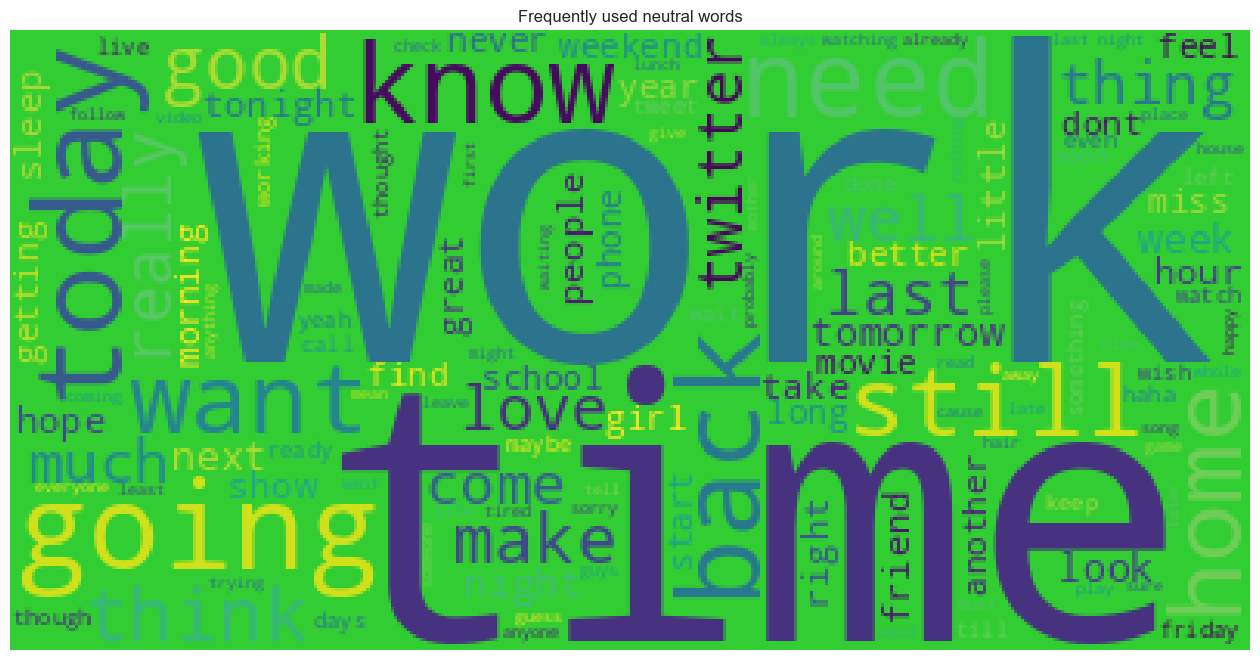

In [18]:
list_text = df['cleaned_text'].astype(str).tolist()
list_pos_text = df_pos['cleaned_text'].astype(str).tolist()
list_neg_text = df_neg['cleaned_text'].astype(str).tolist()
list_neut_text = df_neut['cleaned_text'].astype(str).tolist()

plt.figure(figsize=[16, 10])
plt_wordcloud(list_text, 'white', 'Frequently used words in general')
plt.figure(figsize=[16, 10])
plt_wordcloud(list_pos_text, 'coral', 'Frequently used positive words')
plt.figure(figsize=[16, 10])
plt_wordcloud(list_neg_text, 'navy', 'Frequently used negative words')
plt.figure(figsize=[16, 10])
plt_wordcloud(list_neut_text, 'limegreen', 'Frequently used neutral words')
plt.show()

## Predictive Modeling

In this section, I built three classifier models, namely Naive Bayes, Decision Tree, and Random Forest, to test their abilities in successfully classifying tweet sentiments. I split the dataset into training and tetsing set of size 8:2. 

In the previous preprocessing part, I already done the following: 

For the X variable, I converted the tweets from text format to numbers using 'Bag of Words' method.

For the y variable, I also labeled the 'sentiment' column into: {'negative': 0, 'neutral': 1, 'positive': 2} 

Now I can use machine learning classifier models to test their predictablity in classifying twitter sentiments.

In [19]:
# train, test split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [20]:
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(21984, 1500)
(5496, 1500)
(21984,)
(5496,)


In [21]:
class model_result():
    def __init__(self, model, X_train, y_train, X_validation, y_validation):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = model.predict(self.X_validation)

    def cross_val(self, k = 5):
        cross_val_scores = cross_val_score(self.model,self.X_train, self.y_train, cv=k)
        cross_val_avg = cross_val_scores.mean()
        print("cross val: {}".format(cross_val_avg))

    def acc_rec_pre(self, output_dict):
        if output_dict==True:
            return classification_report(self.y_validation, self.y_pred, output_dict=True)
        else:
            print(classification_report(self.y_validation, self.y_pred, output_dict=False))

    def ROC(self):
        return roc_auc(self.model,self.X_train, self.y_train, X_test=self.X_validation, y_test=self.y_validation)
        
    def get_pred(self):
        return self.y_pred

### Naive Bayes Model

In [22]:
NB_model = model_result(GaussianNB(), X_train, y_train, X_validation, y_validation)

In [23]:
NB_model.cross_val()
NB_model.acc_rec_pre(output_dict=False)

cross val: 0.45755964599074195
              precision    recall  f1-score   support

           0       0.51      0.56      0.54      1491
           1       0.52      0.13      0.20      2274
           2       0.42      0.80      0.55      1731

    accuracy                           0.46      5496
   macro avg       0.48      0.50      0.43      5496
weighted avg       0.49      0.46      0.40      5496



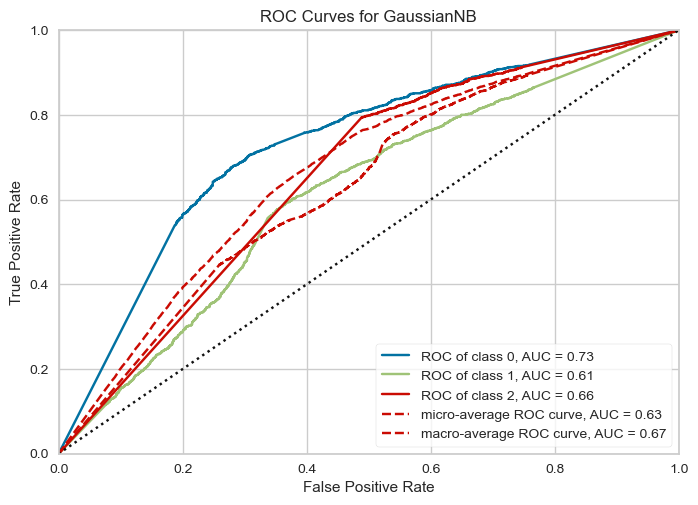

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GaussianNB())

In [24]:
NB_model.ROC()

### Decision Tree Classifier

In [25]:
DT_model = model_result(DecisionTreeClassifier(), X_train, y_train, X_validation, y_validation)

In [26]:
DT_model.cross_val()
DT_model.acc_rec_pre(output_dict=False)

cross val: 0.6108080246623608
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1491
           1       0.59      0.59      0.59      2274
           2       0.70      0.65      0.67      1731

    accuracy                           0.61      5496
   macro avg       0.61      0.61      0.61      5496
weighted avg       0.61      0.61      0.61      5496



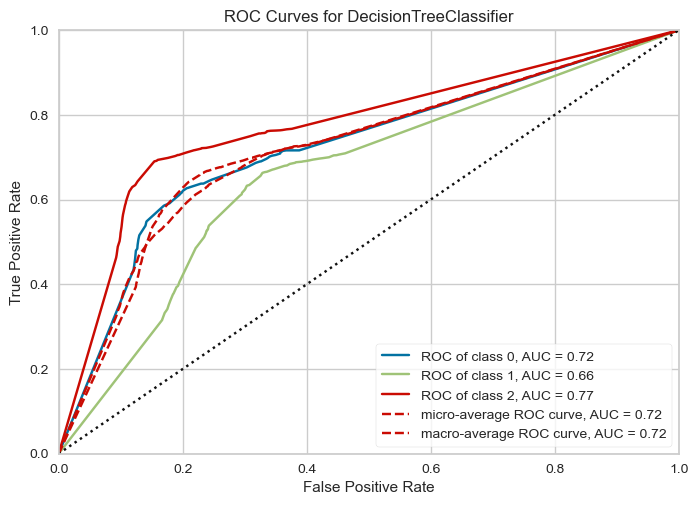

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=DecisionTreeClassifier())

In [27]:
DT_model.ROC()

### Random Forest Classification Model

In [28]:
RF_model = model_result(RandomForestClassifier(), X_train, y_train, X_validation, y_validation)

In [29]:
RF_model.cross_val()
RF_model.acc_rec_pre(output_dict=False)

cross val: 0.6560682556536708
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      1491
           1       0.64      0.65      0.65      2274
           2       0.72      0.73      0.72      1731

    accuracy                           0.66      5496
   macro avg       0.66      0.66      0.66      5496
weighted avg       0.66      0.66      0.66      5496



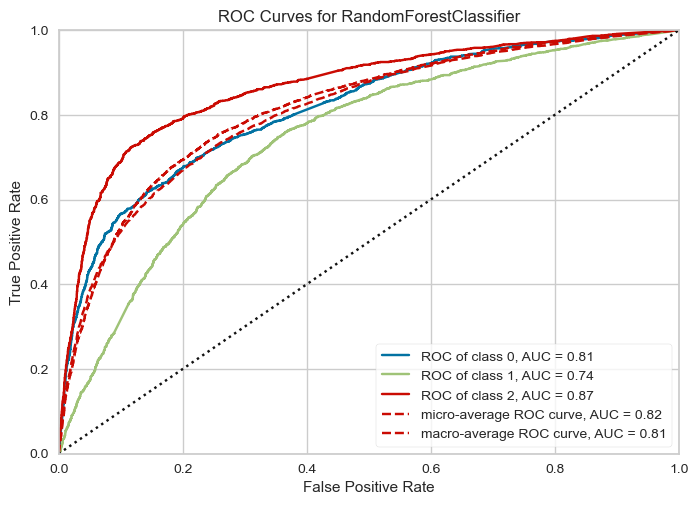

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomForestClassifier())

In [30]:
RF_model.ROC()

### Model Comparison

In [36]:
NB_acc = NB_model.acc_rec_pre(output_dict=True)['accuracy']
DT_acc = DT_model.acc_rec_pre(output_dict=True)['accuracy']
RF_acc = RF_model.acc_rec_pre(output_dict=True)['accuracy']

NB_f1_0 = NB_model.acc_rec_pre(output_dict=True)['0']['f1-score']
DT_f1_0 = DT_model.acc_rec_pre(output_dict=True)['1']['f1-score']
RF_f1_0 = RF_model.acc_rec_pre(output_dict=True)['2']['f1-score']

NB_f1_1 = NB_model.acc_rec_pre(output_dict=True)['0']['f1-score']
DT_f1_1 = DT_model.acc_rec_pre(output_dict=True)['1']['f1-score']
RF_f1_1 = RF_model.acc_rec_pre(output_dict=True)['2']['f1-score']

NB_f1_2 = NB_model.acc_rec_pre(output_dict=True)['0']['f1-score']
DT_f1_2 = DT_model.acc_rec_pre(output_dict=True)['1']['f1-score']
RF_f1_2 = RF_model.acc_rec_pre(output_dict=True)['2']['f1-score']

In [37]:
performance_matrix = pd.DataFrame([NB_acc, DT_acc, RF_acc], \
    index=['Naive Bayes','Decision Tree Classifier','Random Forest'],columns=['accuracy(out of sample)'])

performance_matrix['f1_score_class_0'] = [NB_f1_0, DT_f1_0, RF_f1_0]
performance_matrix['f1_score_class_1'] = [NB_f1_1, DT_f1_1, RF_f1_1]
performance_matrix['f1_score_class_2'] = [NB_f1_2, DT_f1_2, RF_f1_2]
performance_matrix = performance_matrix.round(4)

print(tabulate(performance_matrix, headers='keys', tablefmt='pretty'))

+--------------------------+-------------------------+------------------+------------------+------------------+
|                          | accuracy(out of sample) | f1_score_class_0 | f1_score_class_1 | f1_score_class_2 |
+--------------------------+-------------------------+------------------+------------------+------------------+
|       Naive Bayes        |         0.4578          |      0.5368      |      0.5368      |      0.5368      |
| Decision Tree Classifier |         0.6115          |      0.5941      |      0.5941      |      0.5941      |
|      Random Forest       |          0.663          |      0.7247      |      0.7247      |      0.7247      |
+--------------------------+-------------------------+------------------+------------------+------------------+


We can see from the comparison table that, among the three classifiers, the Random Forest Classifier performs the best, with the highest accuracy of 0.663 and highest f1 scores of 0.7247 . 

Therefore, it performs best in the classification task in the prediction for twitter sentiments

## Sentiment Tagging using Textblob and VaderSentiment

In the originial dataset, the sentiment of each tweet is already tagged. Assume that the tagging is correct, in this section, I wanted to further employ Textblob and VaderSentiment and re-tag the tweets again, to see that how they perform in determining the sentiment for the tweets in comparison to our original benchmark. 

References:

* TextBlob: 
    https://github.com/sloria/TextBlob
    
    https://textblob.readthedocs.io/en/dev/

* VaderSentiment: https://github.com/cjhutto/vaderSentiment

### TextBlob

In [62]:
# function to get subjectivity
# subjectivity is in range [0,1]
def textblob_subjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity 

# function to get polarity 
# polarity is in range [-1,1]
def textblob_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity 

# function to get sentiment based on polarity
def textblob_sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [86]:
df_textblob = pd.DataFrame(df[['text', 'cleaned_text','sentiment']])
df_textblob.rename(columns={'sentiment':'original_tag'}, inplace=True)
df_textblob

,text,cleaned_text,original_tag
0,"I`d have responded, if I were going",responded going,neutral
1,Sooo SAD I will miss you here in San Diego!!!,sooo miss diego,negative
2,my boss is bullying me...,boss bullying,negative
3,what interview! leave me alone,interview leave alone,negative
4,"Sons of ****, why couldn`t they put them on t...",sons releases already bought,negative
...,...,...,...
27476,wish we could come see u on Denver husband l...,wish could come denver husband lost afford,negative
27477,I`ve wondered about rake to. The client has ...,wondered rake client made clear force devs lea...,negative
27478,Yay good for both of you. Enjoy the break - y...,good enjoy break probably need hectic weekend ...,positive
27479,But it was worth it ****.,worth,positive


In [87]:
df_textblob['subjectivity'] = df_textblob['cleaned_text'].apply(textblob_subjectivity)
df_textblob['polarity'] = df_textblob['cleaned_text'].apply(textblob_polarity)
# create a column to store tagging by textblob
df_textblob['textblob_tag'] = df_textblob['polarity'].apply(textblob_sentiment)
df_textblob.head()

,text,cleaned_text,original_tag,subjectivity,polarity,textblob_tag
0,"I`d have responded, if I were going",responded going,neutral,0.0,0.0,neutral
1,Sooo SAD I will miss you here in San Diego!!!,sooo miss diego,negative,0.0,0.0,neutral
2,my boss is bullying me...,boss bullying,negative,0.0,0.0,neutral
3,what interview! leave me alone,interview leave alone,negative,0.0,0.0,neutral
4,"Sons of ****, why couldn`t they put them on t...",sons releases already bought,negative,0.0,0.0,neutral


### VaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

About the scoring:

* The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

* It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:
    1. positive sentiment: compound score >= 0.05
    2. neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    3. negative sentiment: compound score <= -0.05

In [88]:
# function to get sentiment score and tagging using vader

def vader_sentiment(df):
    analyzer = SentimentIntensityAnalyzer()

    # nested function to retrieve sentiment score from vader analyzer
    def vader_sentiment_score(sentence):
        return analyzer.polarity_scores(sentence)['compound']
    
    df['vader_sentiment_score'] = df['cleaned_text'].astype(str).apply(vader_sentiment_score)
    df['vader_tag'] = df['vader_sentiment_score'].apply(lambda score: 'positive' if score > 0.05 else ('neutral' if score > -0.05 else 'negative'))
    return df 


In [89]:
df_vader = df_textblob.copy()
df_vader = vader_sentiment(df_vader)
df_vader.head()

,text,cleaned_text,original_tag,subjectivity,polarity,textblob_tag,vader_sentiment_score,vader_tag
0,"I`d have responded, if I were going",responded going,neutral,0.0,0.0,neutral,0.0000,neutral
1,Sooo SAD I will miss you here in San Diego!!!,sooo miss diego,negative,0.0,0.0,neutral,-0.1531,negative
2,my boss is bullying me...,boss bullying,negative,0.0,0.0,neutral,-0.5994,negative
3,what interview! leave me alone,interview leave alone,negative,0.0,0.0,neutral,-0.2960,negative
4,"Sons of ****, why couldn`t they put them on t...",sons releases already bought,negative,0.0,0.0,neutral,0.0000,neutral


### Comparison

In [91]:
# count number of rows where 'vader_tag' is different from 'original_tag'
# count number of rows where they are different 
textblob_miss_num = df_textblob[df_textblob['textblob_tag'] != df_textblob['original_tag']].count()[0]
print(f'Number of Miss tagged tweets by TextBlob is: {textblob_miss_num}')
print(f'The ratio of Miss tagged tweets by TextBlob among all tweets is: {round(textblob_miss_num/len(df),3)}')

print('=========================================================')
vader_miss_num = df_vader[df_vader['vader_tag'] != df_vader['original_tag']].count()[0]
print(f'Number of Miss tagged tweets by VaderSentiment is: {vader_miss_num}')
print(f'The ratio of Miss tagged tweets by VaderSentiment among all tweets is: {round(vader_miss_num/len(df),3)}')

Number of Miss tagged tweets by TextBlob is: 11328
The ratio of Miss tagged tweets by TextBlob among all tweets is: 0.412
Number of Miss tagged tweets by VaderSentiment is: 10307
The ratio of Miss tagged tweets by VaderSentiment among all tweets is: 0.375


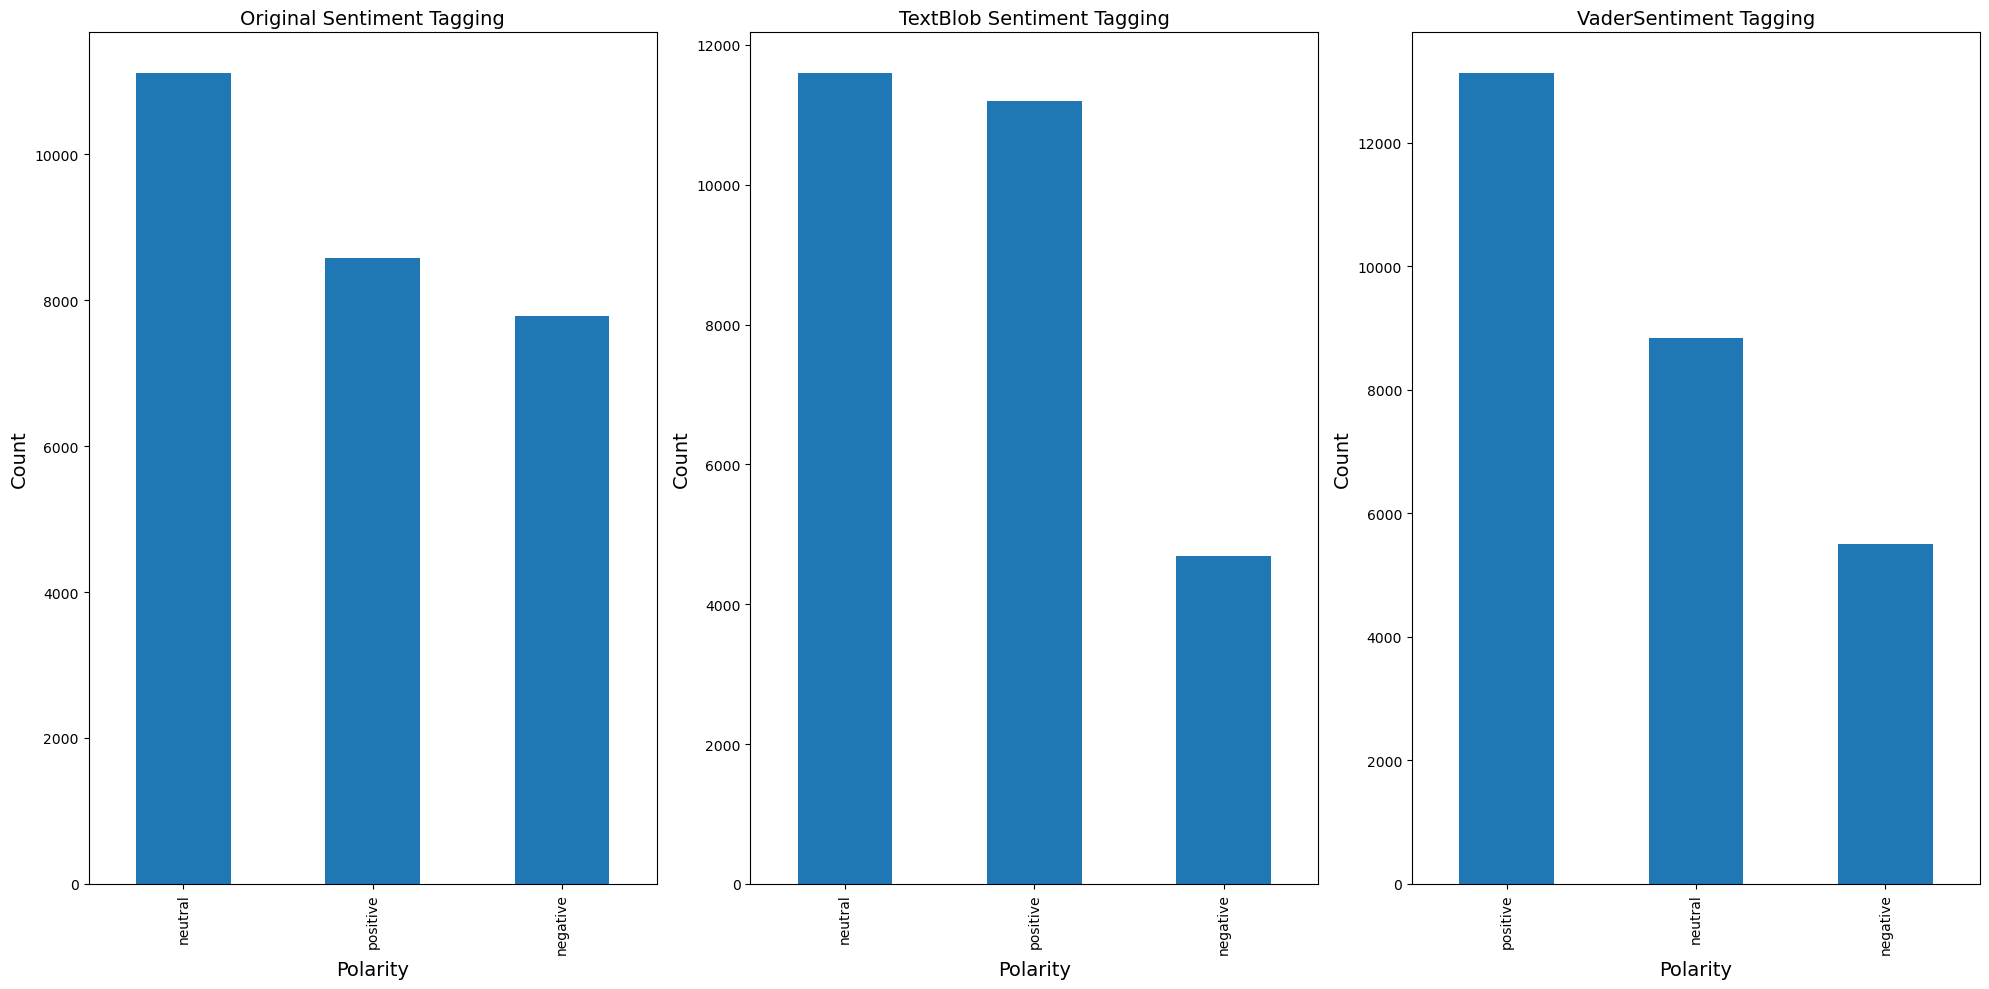

In [105]:
# visualization
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
df_vader['original_tag'].value_counts().plot(kind="bar")
plt.title("Original Sentiment Tagging", fontsize=14)
plt.xlabel("Polarity", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.subplot(1,3,2)
df_vader['textblob_tag'].value_counts().plot(kind="bar")
plt.title("TextBlob Sentiment Tagging", fontsize=14)
plt.xlabel("Polarity", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.subplot(1,3,3)
df_vader['vader_tag'].value_counts().plot(kind="bar")
plt.title("VaderSentiment Tagging", fontsize=14)
plt.xlabel("Polarity", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

From the above comparison, we can see that VaderSentiment performed better than TextBlob in determining the correct sentiment tags and polarity scores for our tweet dataset. The mistag ratio for VaderSentiment is around 37.5%, which is lower than that of TextBlob of 41.2%. 

Furthermore, it shows that both VaderSentiment and TextBlob tend to classify more tweets under the category tag of 'neutral'. And TextBlob tend to classify more tweets as 'positive' as opposed to 'negative', while VaderSentiment could achieve a better balance in distinguishing between good and bad. 